<p><b> <font size="+2"> Table of Contents </font> </b></p>
<p></p>
<a href="#Importing_package and_dataset">Importing package and dataset</a>
<p></p>
<a href="#Data_Cleansing">Data Cleansing</a>
    <UL>
        <LI><a href="#Finding_Duplicate">Finding Duplicate</a>
        <LI><a href="#Finding_missing_data">Finding Missing Data</a>
    </UL>
<a href="#crime_rate_over_time"> Temporal Analysis: Monitoring crimes rate over time</a>
    <UL>
         <LI><a href="#crime_rate_over_time1">Crime Number Trend</a>
         <LI><a href="#crime_rate_over_time2">Overview of different type of crimes in Chicago</a>
    </UL>
<a href="#Locating">Spatial Analysis: Locating crime in Chicago</a>
    <UL>
        <LI><a href="#Preparing_data_for_Choropleth_Map">Preparing data for Police wards and Districts</a>
         <LI><a href="#Creating_Choropleth_Map">Creating Heat Map for Burglary</a>
   </UL>

<a href="#MachineLearning">Crime pattern: Machine Learning Models</a>
    <UL>
        <LI><a href="#xgb">Crime Location Prediction using A XGBoost Tree</a>
         <LI><a href="#Narcotics">Taking a closer look at Narcotics</a>
   </UL>
<a href="#Conclusions">Conclusions and Future Research</a>      
            

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings 
import folium
from xgboost import XGBRegressor
#from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import sklearn.tree as tree
import pydotplus
from IPython.display import Image 
from sklearn.model_selection import train_test_split
import os

# <u>1. Dataset Description </u>
<ul>
    <li><b>df</b> is a dataset of all crimes from 2012 to 2017.
    <li>Each row reports an incident of crime that occurred in the city of Chicago.
    <li>We have 1,450,000 incidents from 2012 to 2017. However, only 11,357 incidents in 2017 so we drop these 2017 incidents.
    <li>Most common primary type of crime is <b>Theft</b>, following by <b>Battery, Criminal Damage </b>, then <b>Narcotics</b>.
</ul>
<b>Important columns in df are:</b>
<ol>
    <li><B>ID:</B> Unique crime identifier. We set this column as primary key.
    <li><B>Date:</B> Date when the incident occurred. This is sometimes a best estimate.
    <li><B>Primary Type:</B> Category of crime ( There are 33 unique categories).
    <li><B>Location Description:</B> Description of the location where the incident occurred.
    <li><B>Arrest:</B> True if criminal was arrested.
    <li><B>Domestic:</B> Indicates whether the incident was domestic-related.
    <li><B>Year:</B> Year the incident occurred.
    <li><B>Ward:</B> The ward (City Council district) where the incident occurred. (There are 50 unique wards).
    <li><B>Latitude:</B> Latitude of the location where the incident occurred.
    <li><B>Longitude:</B> Longitude of the location where the incident occurred.
</ol>

In [ ]:
def Location_extractor(Raw_Str):
    preProcess = Raw_Str[1:-1].split(',')
    lat =  float(preProcess[0])
    long = float(preProcess[1])
    return (lat, long)


#build XGB model
def built_train_model(train_X, train_y, n_estimator = 100, learning_rate = 0.1, early_stopping_rounds = None):
    my_model = XGBRegressor(objective ='reg:squarederror', n_estimator = n_estimator, learning_rate = learning_rate)
    my_model.fit(train_X, train_y, early_stopping_rounds = early_stopping_rounds,  verbose=False)
    return my_model

# Two targets: longitude and latitude
def predict_location(model_Longitude, model_Latitude, test_X):
    predict_Longitude = model_Longitude.predict(test_X)
    predict_Latitude = model_Latitude.predict(test_X)
    return predict_Latitude, predict_Longitude

# Longtitude MAE and latitude MAE
def predict_compute_MAE(model_Longitude, model_Latitude, test_X, test_y_Latitude, test_y_Longitude):
    predict_Latitude, predict_Longitude = predict_location(model_Longitude, model_Latitude, test_X)
    MAE_Latitude = mean_absolute_error(predict_Latitude, test_y_Latitude)
    MAE_Longitude = mean_absolute_error(predict_Longitude, test_y_Longitude)   
    return MAE_Latitude, MAE_Longitude

# Visualize location prediction error
def plot_error(test_X, test_y):
    test_y_Latitude_h = test_y.Latitude.tolist()
    test_y_Longitude_h = test_y.Longitude.tolist()
    predict_Latitude_h, predict_Longitude_h = predict_location(my_model_Longitude, my_model_Latitude, test_X)
    for i in range(0, len(test_y_Latitude_h)):
        plt.plot([test_y_Latitude_h[i],predict_Latitude_h[i]],[test_y_Longitude_h[i],predict_Longitude_h[i]], marker = 'o')
    plt.show()
    
def haversine_np(lon1, lat1):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, long_mean, lat_mean])

    distance_lon = lon2 - lon1
    distance_lat = lat2 - lat1

    a = np.sin(distance_lat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(distance_lon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

<p id="Data_Cleansing"><center> <h1> <b> <font size="+2">Data Cleansing</font></b></h1></center></p>

<p>Now that all the data has been combined into one dataframe, we will need to do some data cleansing</center></p>

* #### Remove incidents occured in 2017
* #### Remove null value for Latitude & Longitude as our analysis is based on these variables
* #### Adding the "year, month, day" column by extracting values from the 'Date' column for further analysis

In [ ]:
%matplotlib inline
plt.style.use('seaborn')


## Read Data
# The 2001 - 2005 data quality seems not good...

crimes1 = pd.read_csv('Chicago_Crimes_2005_to_2007.csv',error_bad_lines=False)
crimes2 = pd.read_csv('Chicago_Crimes_2008_to_2011.csv',error_bad_lines=False)
crimes3 = pd.read_csv('Chicago_Crimes_2012_to_2017.csv',error_bad_lines=False)
crimes = pd.concat([crimes1, crimes2, crimes3], ignore_index=False, axis=0)

# To save some loading time later
# crimes.to_pickle("crime.pkl")
# crimes = pd.read_pickle("crime.pkl")

## Preprocessing
print('Dataset Shape before drop_duplicate : ', crimes.shape)

crimes.drop_duplicates(subset=['ID', 'Case Number'], inplace=True)

print('Dataset Shape after drop_duplicate: ', crimes.shape)

crimes.drop(['Unnamed: 0', 'Case Number', 'IUCR','Updated On','Year', 'FBI Code', 'Beat','Ward','Community Area', 'Location'], inplace=True, axis=1)

# convert dates to pandas datetime format
crimes.Date = pd.to_datetime(crimes.Date, format='%m/%d/%Y %I:%M:%S %p')

# setting the index to be the date will help us a lot later on
crimes.index = pd.DatetimeIndex(crimes.Date)

loc_to_change  = list(crimes['Location Description'].value_counts()[20:].index)
desc_to_change = list(crimes['Description'].value_counts()[20:].index)
#type_to_change = list(crimes['Primary Type'].value_counts()[20:].index)

crimes.loc[crimes['Location Description'].isin(loc_to_change) , crimes.columns=='Location Description'] = 'OTHER'
crimes.loc[crimes['Description'].isin(desc_to_change) , crimes.columns=='Description'] = 'OTHER'

crimes['Primary Type']         = pd.Categorical(crimes['Primary Type'])
crimes['Location Description'] = pd.Categorical(crimes['Location Description'])
crimes['Description']          = pd.Categorical(crimes['Description'])

<p id="crime_rate_over_time"><center> <h1> <b> <font size="+2">Temporal Analysis</font></b></h1></center></p>


<b>Sketch:</b>
<ul>
    <li>The temporal analysis of crime data. 
    <li>Produce analytics to describe patterns in criminal activity based on time. 
    <li>Develop prescriptive analytics through a data science approach, to provide decision-support to law enforcement agencies that want to optimize their tactical crime fighting.
    <li>To be successful at deriving simple and useful insights from temporal crime data, we draw fundamental statistical and mathematical inferences from the data, spot and investigate outliers and analyzed patterns in time series, moreover,draw correlations or causations through regression techniques. Bar charts, line charts, and heat map charts are used to produce decision-support products in the form of tabular data reports.
</ul>



<p id="crime_rate_over_time1"><center> <h1> <b> <font size="+0">Crime Number Trend</font></b></h1></center></p>


Dataset Shape before drop_duplicate :  (4336556, 23)
Dataset Shape after drop_duplicate:  (4336556, 23)


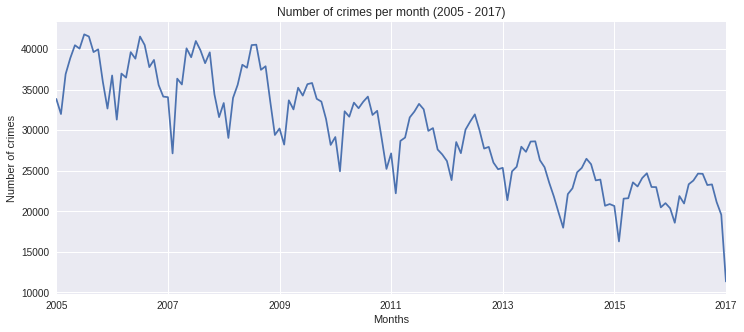

In [10]:
## plot No of crimes per month
plt.figure(figsize=(12,5))
crimes.resample('M').size().plot(legend=False)
plt.title('Number of crimes per month (2005 - 2017)')
plt.xlabel('Months')
plt.ylabel('Number of crimes')
plt.show()

<p id="crime_rate_over_time2"><center> <h1> <b> <font size="+0">Overview of different types of crime in Chicago</font></b></h1></center></p>


Number of crimes seems to be periodic with a period of one year, which suggests that during each year, 
the number of crimes is related to months/season. 

Moreover, it can be read from the graph that during each year, the number of crimes reaches peak in summer and off-peak in winter. This suggests that number of crimes has a high correlation with temperature. 

We are also interested to see different type of crime's trend during 2005-2017, which suggests the police has succeed in supressing certain crime types and should spend more effort on the others.

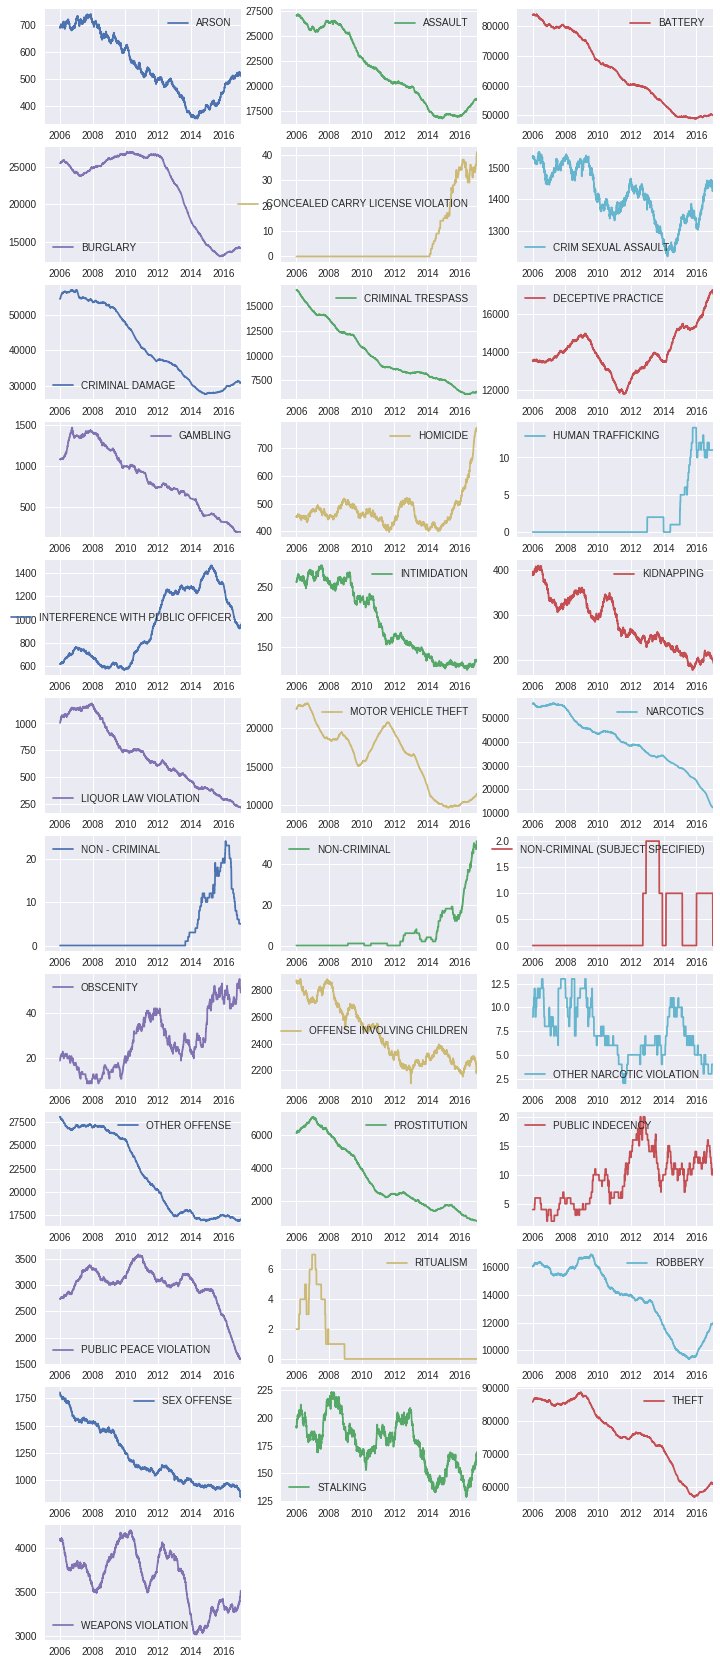

In [11]:
crimes_count_date = crimes.pivot_table('ID', aggfunc=np.size, columns='Primary Type', 
                                       index=crimes.index.date, fill_value=0)
crimes_count_date.index = pd.DatetimeIndex(crimes_count_date.index)
plo = crimes_count_date.rolling(365).sum().plot(figsize=(12, 30), subplots=True, 
                                                layout=(-1, 3), sharex=False, sharey=False)

Taken together, such community level trends show that nearly all crime types in Chicago experienced a decline over the past several decades. 

The Chicago police officers are doing quite a good job at supressing major crimes types, such as the Arson, 
Assult, Burglary, criminal damage, gambling, intimidation, kidnapping, liquor law violation, motor vehicle theft,
prostitution and robbery, all have a significant drop.

While the Concealed carry license violation, interference with public officer, obscenity, public indecency are increasing.

We still don't know which crime type happens most, let's take a look at each crime's number

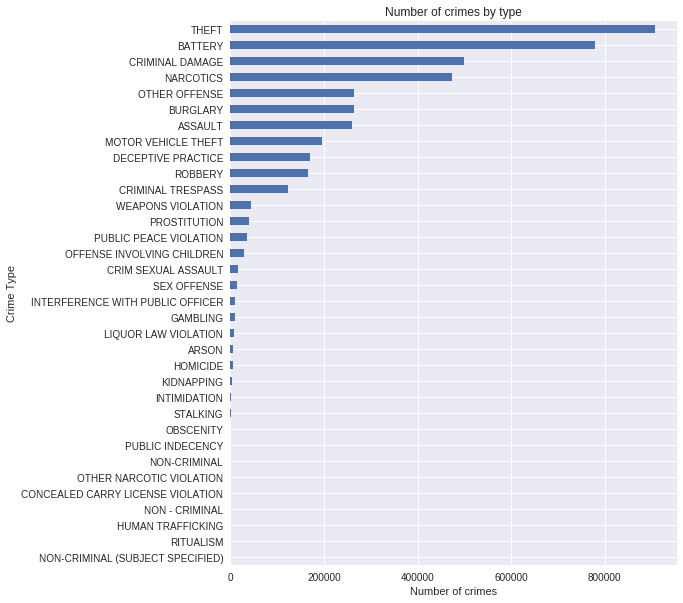

In [14]:
plt.figure(figsize=(8,10))
crimes.groupby([crimes['Primary Type']]).size().sort_values(ascending=True).plot(kind='barh')
plt.title('Number of crimes by type')
plt.ylabel('Crime Type')
plt.xlabel('Number of crimes')
plt.show()

Next, we will take a look at the spacial pattern of crimes.

We use the folium which is a python library builds on the data wrangling strengths of the Python ecosystem and the mapping strengths of the leaflet.js library. Data is visualized on an interactive leaflet map. It enables both the binding of data to a map for choropleth visualizations as well as passing rich vector/raster/HTML visualizations as markers on the map.



<p id="Locating"><center> <h1> <b> <font size="+2">Spatial Analysis: Locating crime in Chicago</font></b></h1></center></p>


<b>Sketch:</b>
<ul> 
    <li> Crime mapping using python geo libraries Foliuma, Pyproj and scikit-image  to visualize and organize spatial data for more formal statistical analysis.
    <li> Employed spatial analysis in both an exploratory and well as a more confirmatory manner to identify how certain community or ecological factors (population characteristics, built environment, etc.) influence the spatial patterns of crime. 
    <li> Provide crime map, which can also be used to visualize and analyze the movement or target selection patterns of criminals. Moreover, allows researchers and practitioners to explore crime patterns, offender mobility, and serial offenses over time and space. 
    <li> Provides visualization of crime clusters by types of crimes, thereby validating the street knowledge of patrol officers. 
    <li> The final goal is to provide suggestions to Chicago Police Department for allocating resources (patrol, specialized enforcement), moreover, inform how the concerns of local citizens are being addressed. 
</ul>

<b>The questions we are aiming to answer are:</b>
<ul> 
    <li> What drives arrests in Chicago? 
    <li> Are there variables that can predict if an arrest will occur or not? 
    <li> Can someone avoid crime while in Chicago? 
    <li> Does the area that you live in greatly impact your likelihood of being arrested? 
    <li> These were some of the questions that we sought to answer for this analysis. 
</ul>
    
Due to the size of this dataset and the limits of my computing power available, I decided to give a overview on the whole 2001-2018 data but focus more on data from 2012 to 2017. 

<p id="Preparing_data_for_Choropleth_Map"><center> <h1> <b> <font size="+0">Preparing data for Police wards and Districts</font></b></h1></center></p>

The below graph displays each crime report on the map. Each circle indicates a crime report filed on that spot, 
and by licking the circle a short description of this crime will pop out. The whole map can be zoomed in/out to show
less/more reports.

In [28]:
df = crimes3

# Preprocessing
df = df.dropna()
df = df.drop(columns=['Unnamed: 0', 'ID', 'Case Number', 'Block', 'IUCR','Domestic', 'Beat', 'District', 'Ward','X Coordinate', 'Y Coordinate','Updated On', 'FBI Code'], axis = 1)

unique_locations = df['Location'].value_counts()

CR_index = pd.DataFrame({"Raw_String" : unique_locations.index, "ValueCount":unique_locations})
CR_index.index = range(len(unique_locations))
CR_index.head()


CR_index['LocationCoord'] = CR_index['Raw_String'].apply(Location_extractor)

CR_index  = CR_index.drop(columns=['Raw_String'], axis = 1)

chicago_map_crime = folium.Map(location=[41.895140898, -87.624255632],
                        zoom_start=13)
                        # tiles="CartoDB dark_matter")

for i in range(500):
    lat = CR_index['LocationCoord'].iloc[i][0]
    long = CR_index['LocationCoord'].iloc[i][1]
    radius = CR_index['ValueCount'].iloc[i] / 45
    
    if CR_index['ValueCount'].iloc[i] > 1000:
        color = "red"
    else:
        color = "#008080"
    
    popup_text = """Latitude : {}<br>
                Longitude : {}<br>
                Criminal Incidents : {}<br>"""
    popup_text = popup_text.format(lat,
                               long,
                               CR_index['ValueCount'].iloc[i]
                               )
    folium.CircleMarker(location = [lat, long], popup= popup_text,radius = radius, color = color, fill = True).add_to(chicago_map_crime)

chicago_map_crime

The circle size represents the number of crimes happening on that spot. The spots which has over 1000 crime 
reports files are drawn by red circles, which suggests to be high crime rate places.

Althought the overall crime rate is decreasing, crime seems to be remaining persistently in particularly
communities, especially in socially and economically disadvantaged parts of the city. As
has been documented elsewhere, the highest crime communities during the height of
the Crack Era remain the highest crime communities today even though their absolute
levels of crime have dropped significantly. 

Additional analysis should be performed to explore the complex reasons such inequality in crime rates persist across time and place persists in Chicago communities. I'm very curious to see each type of crime's spacial pattern, especially robbery, below is to filter the crime type robbery and show on the map.

<p id="Creating_Choropleth_Map"><center> <h1> <b> <font size="+0">Creating Heat Map for Burglary</font></b></h1></center></p>


Crime map helps us to makie sure we understand as much as possible about potential crime in our city or neighborhood.

In [43]:
df_public_peace =  df[df['Primary Type'] == 'ROBBERY']
unique_locations_bombs = df_public_peace['Location'].value_counts()
PB_index = pd.DataFrame({"Raw_String" : unique_locations_bombs.index, "ValueCount":unique_locations_bombs})
PB_index.index = range(len(unique_locations_bombs))
PB_index.head()

PB_index['LocationCoord'] = PB_index['Raw_String'].apply(Location_extractor)
PB_index  = PB_index.drop(columns=['Raw_String'], axis = 1)

chicago_crime_pp = folium.Map(location=[41.795140898, -87.624255632],
                        zoom_start=11)
for i in range(500):
    lat = PB_index['LocationCoord'].iloc[i][0]
    long = PB_index['LocationCoord'].iloc[i][1]
    radius = PB_index['ValueCount'].iloc[i] / 3
    
    if PB_index['ValueCount'].iloc[i] > 30:
        color = "red"
    else:
        color = "blue"
    
    popup_text = """Latitude : {}<br>
                Longitude : {}<br>
                Peace Disruptions : {}<br>"""
    popup_text = popup_text.format(lat,
                               long,
                               PB_index['ValueCount'].iloc[i]
                               )
    folium.CircleMarker(location = [lat, long], popup= popup_text,radius = radius, color = color, fill = True).add_to(chicago_crime_pp)

folium.TileLayer('cartodbpositron').add_to(chicago_crime_pp)

chicago_crime_pp

It seems that the robbery has a much higher rate in the south Chicago, and the west and North disctricts are relatively much safer.

The homicide and violence maps are examined in detail (do not show up here, simply change the 1st line 'ROBBERY' to "HOMICDE" or "VIOLENCE" in the above block to show). The highest rates of homicide and violence
concentrated on the West and South sides of the city, google map shows these are mostly in predominately African American communities, such as East and West Garfield Park, Englewood, and Fuller Park

The average homicide rate from 2012-2017 in West Garfield Park was nearly
64 per 100,000 residents, whereas the average homicide rate in Jefferson Park, located
on Chicago’s Northwest side, was only 3.10 per 100,000 residents. 

Lincoln Square, Lake View, North Park, Jefferson Park and Montclare are the most low-crime communities.

<p id="MachineLearning"><center> <h1> <b> <font size="+2">Crime pattern: Machine Learning Models</font></b></h1></center></p>


Data mining and machine learning have become a vital part of crime detection and prevention. 

Next, we perform a comparative study if the violent crime patterns.

<p id="xgb"><center> <h1> <b> <font size="+0">Crime Location Prediction using A XGBoost Tree</font></b></h1></center></p>

In [17]:
my_data = crimes3
my_data['Date'] = pd.to_datetime(my_data['Date'])
my_data = my_data.dropna()

# Split to year/month/day/hour/min
my_data.insert(0,'Date_year',(my_data.Date.map(lambda x:x.year)))
my_data.insert(0,'Date_month',(my_data.Date.map(lambda x:x.month)))
my_data.insert(0,'Date_day',(my_data.Date.map(lambda x:x.day)))
my_data.insert(0,'Date_hour',(my_data.Date.map(lambda x:x.hour)))
my_data.insert(0,'Date_minute',(my_data.Date.map(lambda x:x.minute)))

# Features: Date(_year, _month, _day, _hour, _minute), Arrest, Domestic, Primary Type
# Targat: lantitude and longitude

#X = my_data[['Date_year','Date_month','Date_day'，'Date_hour','Date_minute','Arrest','Domestic','Primary Type']]
X = my_data[['Date_year','Date_month','Date_hour','Date_day','Date_minute','District','Arrest','Domestic','Primary Type']]
y = my_data[['Latitude', 'Longitude']]


# Train / test
train_X, test_X, train_y, test_y = train_test_split(X,y)

# Deal with discrete features, align train/test sets
train_X = pd.get_dummies(train_X)
test_X = pd.get_dummies(test_X)
train_X, test_X = train_X.align(test_X, join = 'left', axis = 1)

# y: Latitude, Longitude
train_y_Latitude = train_y.Latitude
train_y_Longitude = train_y.Longitude
test_y_Latitude = test_y.Latitude
test_y_Longitude = test_y.Longitude

Let's train a XGB. Some of pros and cons of this model are:

<b>Pros:</b>
<ul>
<li> Easily interpretable. 
    <li> Relatively fast to construct.
    <li> Naturally deal with both continuous and categorical data.
    <li> Naturally deal with missing data.
    <li> Robust to outliers in the inputs.
    <li> Invariant under monotone transformations of the inputs.
    <li> Perform implicit variable selection.
    <li> Can capture non-linear relationships in the data.
    <li> Can capture high-order interactions between inputs.
    <li> Scale well to large data sets.
</ul>


<b>Cons: </b>
<ul>
<li> Easily interpretable. 
 <li> Tend to select predictors with a higher number of distinct values.
 <li> Can overfit when faced with predictors with many categories.
 <li> Are unstable and have high variance.
 <li> Lack smoothness.
 <li> Have difficulty capturing additive structure.
 <li> Tend to have limited predictive performance.
</ul>





XGBOOST is a little bit hard to tune compare to other ensembling algorithms like random forest. Since XGBOOST at each iteration needs the previous step to calculate gradients it cannot be done in parallel like random forest. But XGBOOST due to some benchmarks can have higher accuracy.


/home/kaizhang/anaconda3/envs/dataIncu/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/kaizhang/anaconda3/envs/dataIncu/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


Prediction error:  (0.011085692852196467, 0.014497839289095696)
(array([41.689102, 41.88013 , 41.806805, 41.744514, 41.94548 ],
      dtype=float32), array([-87.62077 , -87.715324, -87.60971 , -87.63046 , -87.65753 ],
      dtype=float32))
          Latitude  Longitude
1197620  41.711905 -87.627229
1090678  41.876861 -87.744037
943936   41.801418 -87.584734
54332    41.750446 -87.602733
855423   41.925388 -87.652907
Visualize data


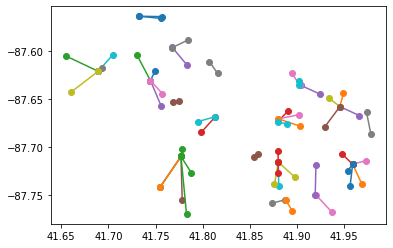

In [20]:
#Train model and print two MAE
my_model_Longitude = built_train_model(train_X, train_y_Longitude)
my_model_Latitude = built_train_model(train_X, train_y_Latitude)
print('Prediction error: ', predict_compute_MAE(my_model_Longitude, my_model_Latitude, test_X, test_y_Latitude, test_y_Longitude))

print(predict_location(my_model_Longitude, my_model_Latitude, test_X.head()))
print(test_y.head())

print("Visualize data")
plot_error(test_X[60:110], test_y[60:110])

Using a XGBoost tree model, the crime location information is predicted using the time and crime type information. The prediction error is roughly less than 1.5%. 



In [32]:
df = crimes3
df.set_index('ID',inplace=True)
df2=df.copy()
df2.drop(columns=['Unnamed: 0','Case Number','Block','IUCR','FBI Code','Updated On','X Coordinate','Beat','District',\
                  'Community Area','Y Coordinate','Location'],inplace=True)
df2 = df2[~(df2.Year == 2017)]
df2=df2.loc[~df2['Latitude'].isnull()]
df2['Arrest']=(df.Arrest==True)*1
df2['Domestic']=(df.Domestic==True)*1
df2['month']=df2.Date.astype(np.datetime64).dt.month
df2.groupby('Ward')['Arrest'].sum().nlargest(1)
lat_mean=df2[df2.Ward==28].Latitude.mean()
long_mean=df2[df2.Ward==28].Longitude.mean()
location_mean=[lat_mean,long_mean]
location_mean


from haversine import *


df2['distance']=df2.apply(lambda x: haversine_np(x.Longitude,x.Latitude),axis=1)
df2['crime_year']=df2.groupby('Year')['Arrest'].transform('size')
df2['crime_year_ward']=df2.groupby(['Ward','Year'])['Arrest'].transform('size')
df2['rate_ward_year']=df2.crime_year_ward/df2.crime_year
df2['mean_crime_year']=df2.groupby('Year')['rate_ward_year'].transform('mean')
df2['unsafe']=(df2.rate_ward_year>df2['mean_crime_year'])*1
df2.drop(columns=['Latitude', 'Longitude', 'crime_year', 'crime_year_ward', 'rate_ward_year', 'mean_crime_year', \
                  'Date','Description','Location Description','Ward'], inplace=True)

df3 = df2.copy()
df2= pd.get_dummies(df2,columns=['Primary Type'])

<p id="Narcotics"><center> <h1> <b> <font size="+0">Taking a closer look at Narcotics</font></b></h1></center></p>

I used a 4-level decision tree to model the "safer places" based on the time data and crime type data. Basically, based on the crime happening time and location, the models learns if a specific location will be safe or not, thus could give a rough guide to people to avoid certain places during certain time. 

Based on the data, Ward #28 is the place where most crimes occured. We first calculate the distances in kilometres between ward 28 and other locations where incident of crime occurred, using Haversine package. 

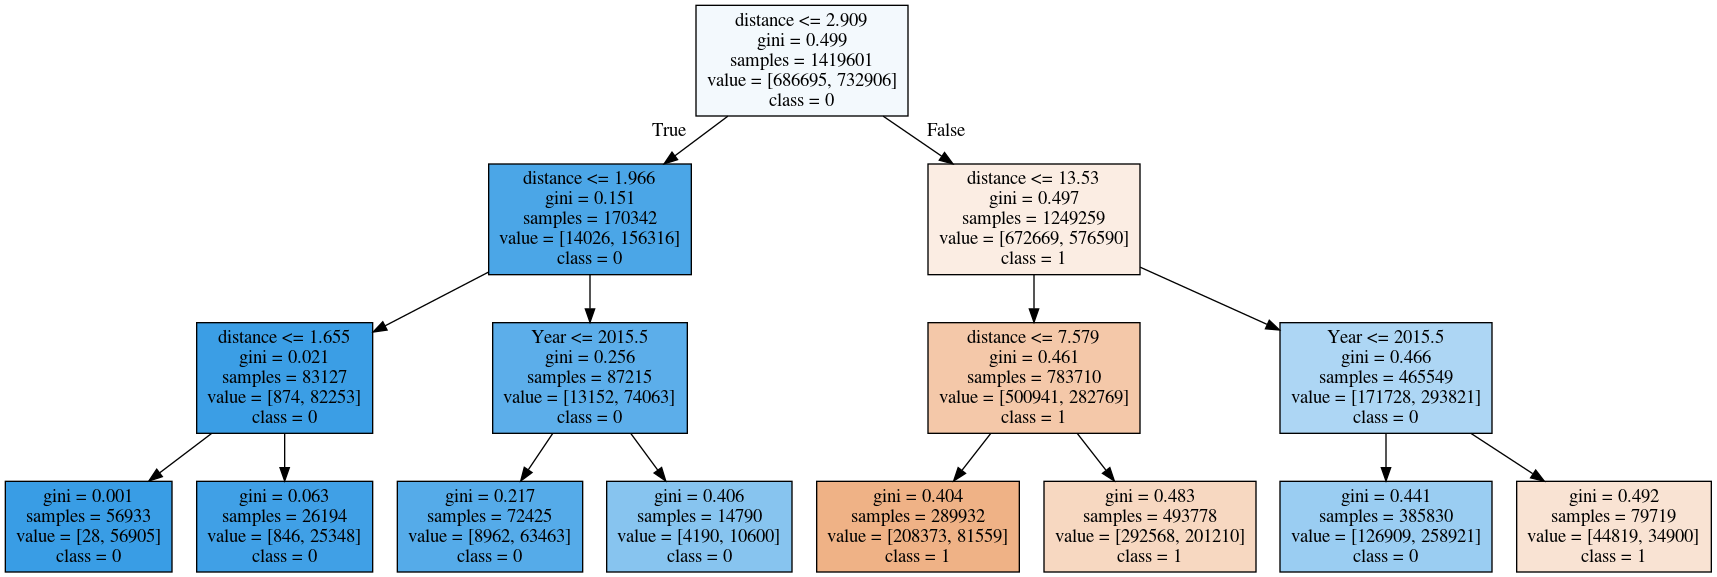

In [33]:
x=df2.drop(columns='unsafe')
y=df2.unsafe
dt = tree.DecisionTreeClassifier(max_depth = 3)
dt.fit(x,y)
dt_feature_names = list(x.columns)
dt_target_names = np.array(y.unique(),dtype=np.str) 
tree.export_graphviz(dt, out_file='tree.dot', 
    feature_names=dt_feature_names, class_names=dt_target_names,
    filled=True)  
graph = pydotplus.graph_from_dot_file('tree.dot')
Image(graph.create_png())

Locations that are located less than 3 km away from ward 28 are more likely to be very unsafe. From this, we want to explore more about what the differences between the locations less than 3km and greater than 3km from the ward 28 (the ward with the most incidents of crime).

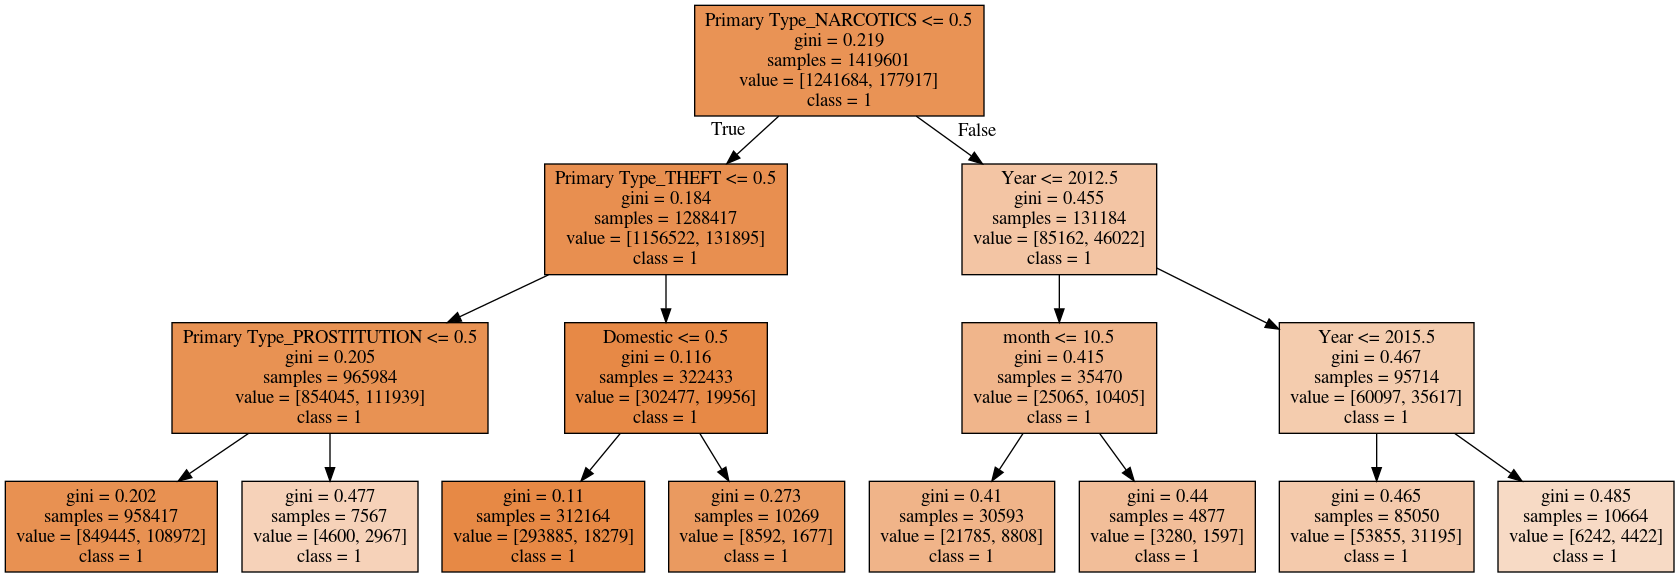

In [34]:
df2['is_distance_3km']=(df2.distance<3)*1
df2.drop(columns = ['unsafe','distance'], inplace = True)
x=df2.drop(columns='is_distance_3km')
y=df2.is_distance_3km
dt = tree.DecisionTreeClassifier(max_depth = 3)
dt.fit(x,y)

dt_feature_names = list(x.columns)
dt_target_names = np.array(y.unique(),dtype=np.str) 
tree.export_graphviz(dt, out_file='tree.dot', 
    feature_names=dt_feature_names, class_names=dt_target_names,
    filled=True)  
graph = pydotplus.graph_from_dot_file('tree.dot')
Image(graph.create_png())

Narcotics is a higher contributer of crime for the most highly unsafe regions (locations less than 3 km). Out of total crimes for the locations less than 3km (177,917 incidents), we see that 46,022 incidents of narcotics are present. Hence, narcotics is 25.9% of the total crimes for locations with distance less than 3km.
However, for the distance greater than 3km, narcotics is only 6.9% (=85,162/1,241,684) of all the crimes.
Similarly theft is only a 11.2% (=19,956/177,917) contributer of total crimes for the locations with distance less than 3km. But for the distance greater than 3km, it is a 24.4% (=302,477/1,241,684) contribtutor.
So narcotics is more likely to present in the locations with distance less than 3km as compared to theft, even though, overall in the whole data set, theft is the most common crime.


<p id="Conclusions"><center> <h1> <b> <font size="+2">Conclusions and Future Research</font></b></h1></center></p>


In conclusion, narcotics are more likely to occur than theft for the most highly unsafe regions in Chicago (locations with distance less than 3 kilometers from the location with the most incidents of crime, i.e ward 28). And theft is not the most common crime in these regions, even though theft is the most prevalent in the dataset.

This means that these regions are unsafe because of the higher concentration of crimes related to narcotics. This is a surprised finding, because overall, theft is the most prevalent crime with 22%, while narcotics is the 4th one with only 9%. At first, we had expected that the highest crime rate regions (locations with distance less than 3km) would have had higher rate of theft. However, it turns out that in these regions, crimes related to narcotics are even more frequent.

Hence, our suggestion is that for these unsafe regions, the police better watch out for narcotics crimes to prevent all actions and consequences related to narcotics. And police also better watch out for drug users in these regions becasue drug users are supposed to be more likely than nonusers to commit crimes. Handling these crimes may make these regions safer in the future, and overall not getting the bad reputation as being an unsafe region.

### Future Explorations: 

The above analysis provides a preliminary framework for further analyses. Other machine learning models such as KNN, decision tree, rule induction, nearest-neighbor method, and genetic algorithm, and deep learning methods are worth a try.

Prediction models from multiple domains such as demographics, economics, and education, and it turns out that they treat data from different domains equally. These methods can be used in crime occurrence prediction. Moreover, we can even model in the environmental context information such as "broken windows theory" into our DNN model. Thus we can fuse all spatial, temporal, environmental context information together. The fusion DNN is a product of an efficient decision-making process that predicts crime occurance time and location and hopefully will be more accurate in predicting crime occurrence than other prediction models.